# 24

In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [53]:
import tensorflow as tf
import numpy as np
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
df_all = pd.read_pickle('../data/df_19_24_cleaned.pkl') 

In [55]:
df = df_all['2022': '2024']

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24841 entries, 2022-01-01 00:00:00 to 2024-11-01 00:00:00
Freq: h
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          24841 non-null  float64
 1   solar          24841 non-null  int64  
 2   wind_onshore   24841 non-null  int64  
 3   wind_offshore  24841 non-null  int64  
 4   total_load     24841 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 1.1 MB


## Feature Selection

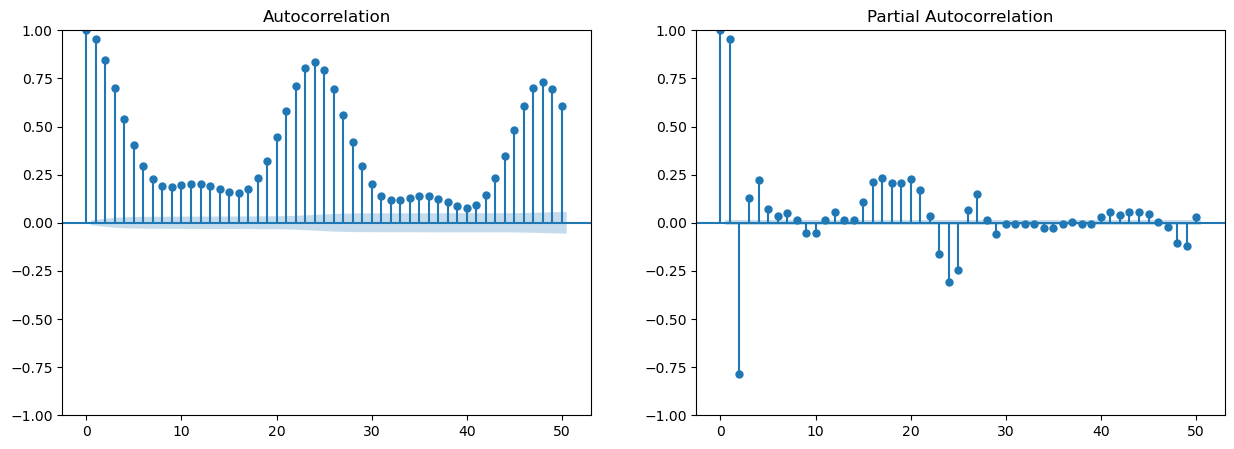

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming df has a datetime index and 'value' is the target column
y = df['total_load']

# Plot ACF and PACF for weekly lags
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(y, lags=50, ax=axes[0])  # ACF up to 1 week (168 hours)
plot_pacf(y, lags=50, ax=axes[1])  # PACF up to 1 week (168 hours)
plt.show()

In [58]:
# Create lagged features
# df.loc[:, 'price_lag_1'] = df.loc[:,'price'].shift(1)
# df.loc[:, 'price_lag_2'] = df.loc[:,'price'].shift(2)
# df.loc[:, 'price_lag_25'] = df.loc[:,'price'].shift(1)

In [59]:
# # Example using PyEWT; install and import if available
# from PyEMD import EWT
# import numpy as np

# ewt = EWT()

# # Apply EWT to each feature and add decomposed components to the DataFrame
# for feature in ['price', 'wind_onshore', 'wind_offshore', 'solar', 'total_load']:
#     signal = df[feature].values  # Get the feature's time series data
    
#     # Decompose using EWT
#     components = ewt(signal)  # Decompose into frequency bands
    
#     # Add each component as a new column in the DataFrame
#     df[f'{feature}_low_freq'] = components[:, 0]
#     df[f'{feature}_mid_freq'] = components[:, 1]
#     df[f'{feature}_high_freq'] = components[:, 2]

In [60]:
import pandas as pd

# Define the lags you want to explore
lags = [1, 2, 25]
features = ['price','wind_onshore', 'wind_offshore', 'solar', 'total_load']
# features = ['wind_onshore', 'wind_offshore', 'solar', 'total_load']
# features = ['wind_onshore', 'wind_offshore', 'solar', 'total_load']
# features = ['price']

# Create lagged features for each feature at specified lags
for feature in features:
    for lag in lags:
        df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)

/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_1478/2704143772.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_1478/2704143772.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_1478/2704143772.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [61]:
# window_sizes = [3, 8, 24]  # Example window sizes
# for window in window_sizes:
#     for feature in ['solar', 'wind_onshore', 'wind_offshore', 'total_load']:
#         df[f'{feature}_ma_{window}'] = df[feature].rolling(window=window).mean()

In [62]:
# Calculate correlations between 'price' and each lagged feature
correlations = {}

for feature in features:
    for lag in lags:
        lagged_column = f"{feature}_lag_{lag}"
        correlation = df['price'].corr(df[lagged_column])
        correlations[lagged_column] = correlation

# Convert correlations to a DataFrame for easy viewing
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation with Price'])
correlation_df.sort_values(by='Correlation with Price', ascending=False, inplace=True)

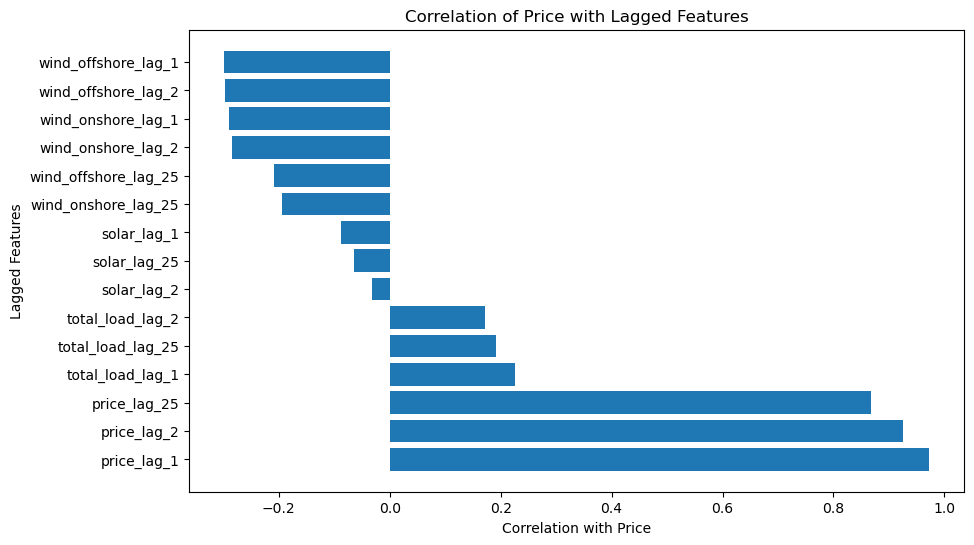

In [63]:
import matplotlib.pyplot as plt

# Plot the correlations
plt.figure(figsize=(10, 6))
plt.barh(correlation_df['Feature'], correlation_df['Correlation with Price'])
plt.xlabel('Correlation with Price')
plt.ylabel('Lagged Features')
plt.title('Correlation of Price with Lagged Features')
plt.show()

In [64]:
# df['price_lag_1'] = df['price'].shift(1)
df['price_moving_avg_8'] = df['price'].rolling(window=8).mean()
df['price_moving_avg_24'] = df['price'].rolling(window=24).mean()

/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_1478/3301015948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_moving_avg_8'] = df['price'].rolling(window=8).mean()
/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_1478/3301015948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_moving_avg_24'] = df['price'].rolling(window=24).mean()


In [65]:
def day_flag(data):
    data['DayOfWeek'] = data.index.dayofweek              # Day of the week (0=Monday, 6=Sunday)
    # data['WeekOfYear'] = data.index.isocalendar().week    # ISO week number of the year
    # data['Day'] = data.index.day                          # Day of the month
    # data['Month'] = data.index.month                      # Month of the year
    # data['Year'] = data.index.year                        # Year
    data['PeriodOfDay'] = data.index.hour                 # Hour of the day (0-23)
    # Add cyclic transformations for HourOfDay and DayOfWeek
    data['HourOfDay_sin'] = np.sin(2 * np.pi * data['PeriodOfDay'] / 24)
    data['HourOfDay_cos'] = np.cos(2 * np.pi * data['PeriodOfDay'] / 24)
    
    data['DayOfWeek_sin'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
    data['DayOfWeek_cos'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)
    
    # Drop original cyclic features if you want to avoid redundancy
    data.drop(['PeriodOfDay', 'DayOfWeek'], axis=1, inplace=True)

    return data

In [66]:
df = day_flag(df)

/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_1478/2653525912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DayOfWeek'] = data.index.dayofweek              # Day of the week (0=Monday, 6=Sunday)
/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_1478/2653525912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PeriodOfDay'] = data.index.hour                 # Hour of the day (0-23)
/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_1478/2653525912.py:9: Setti

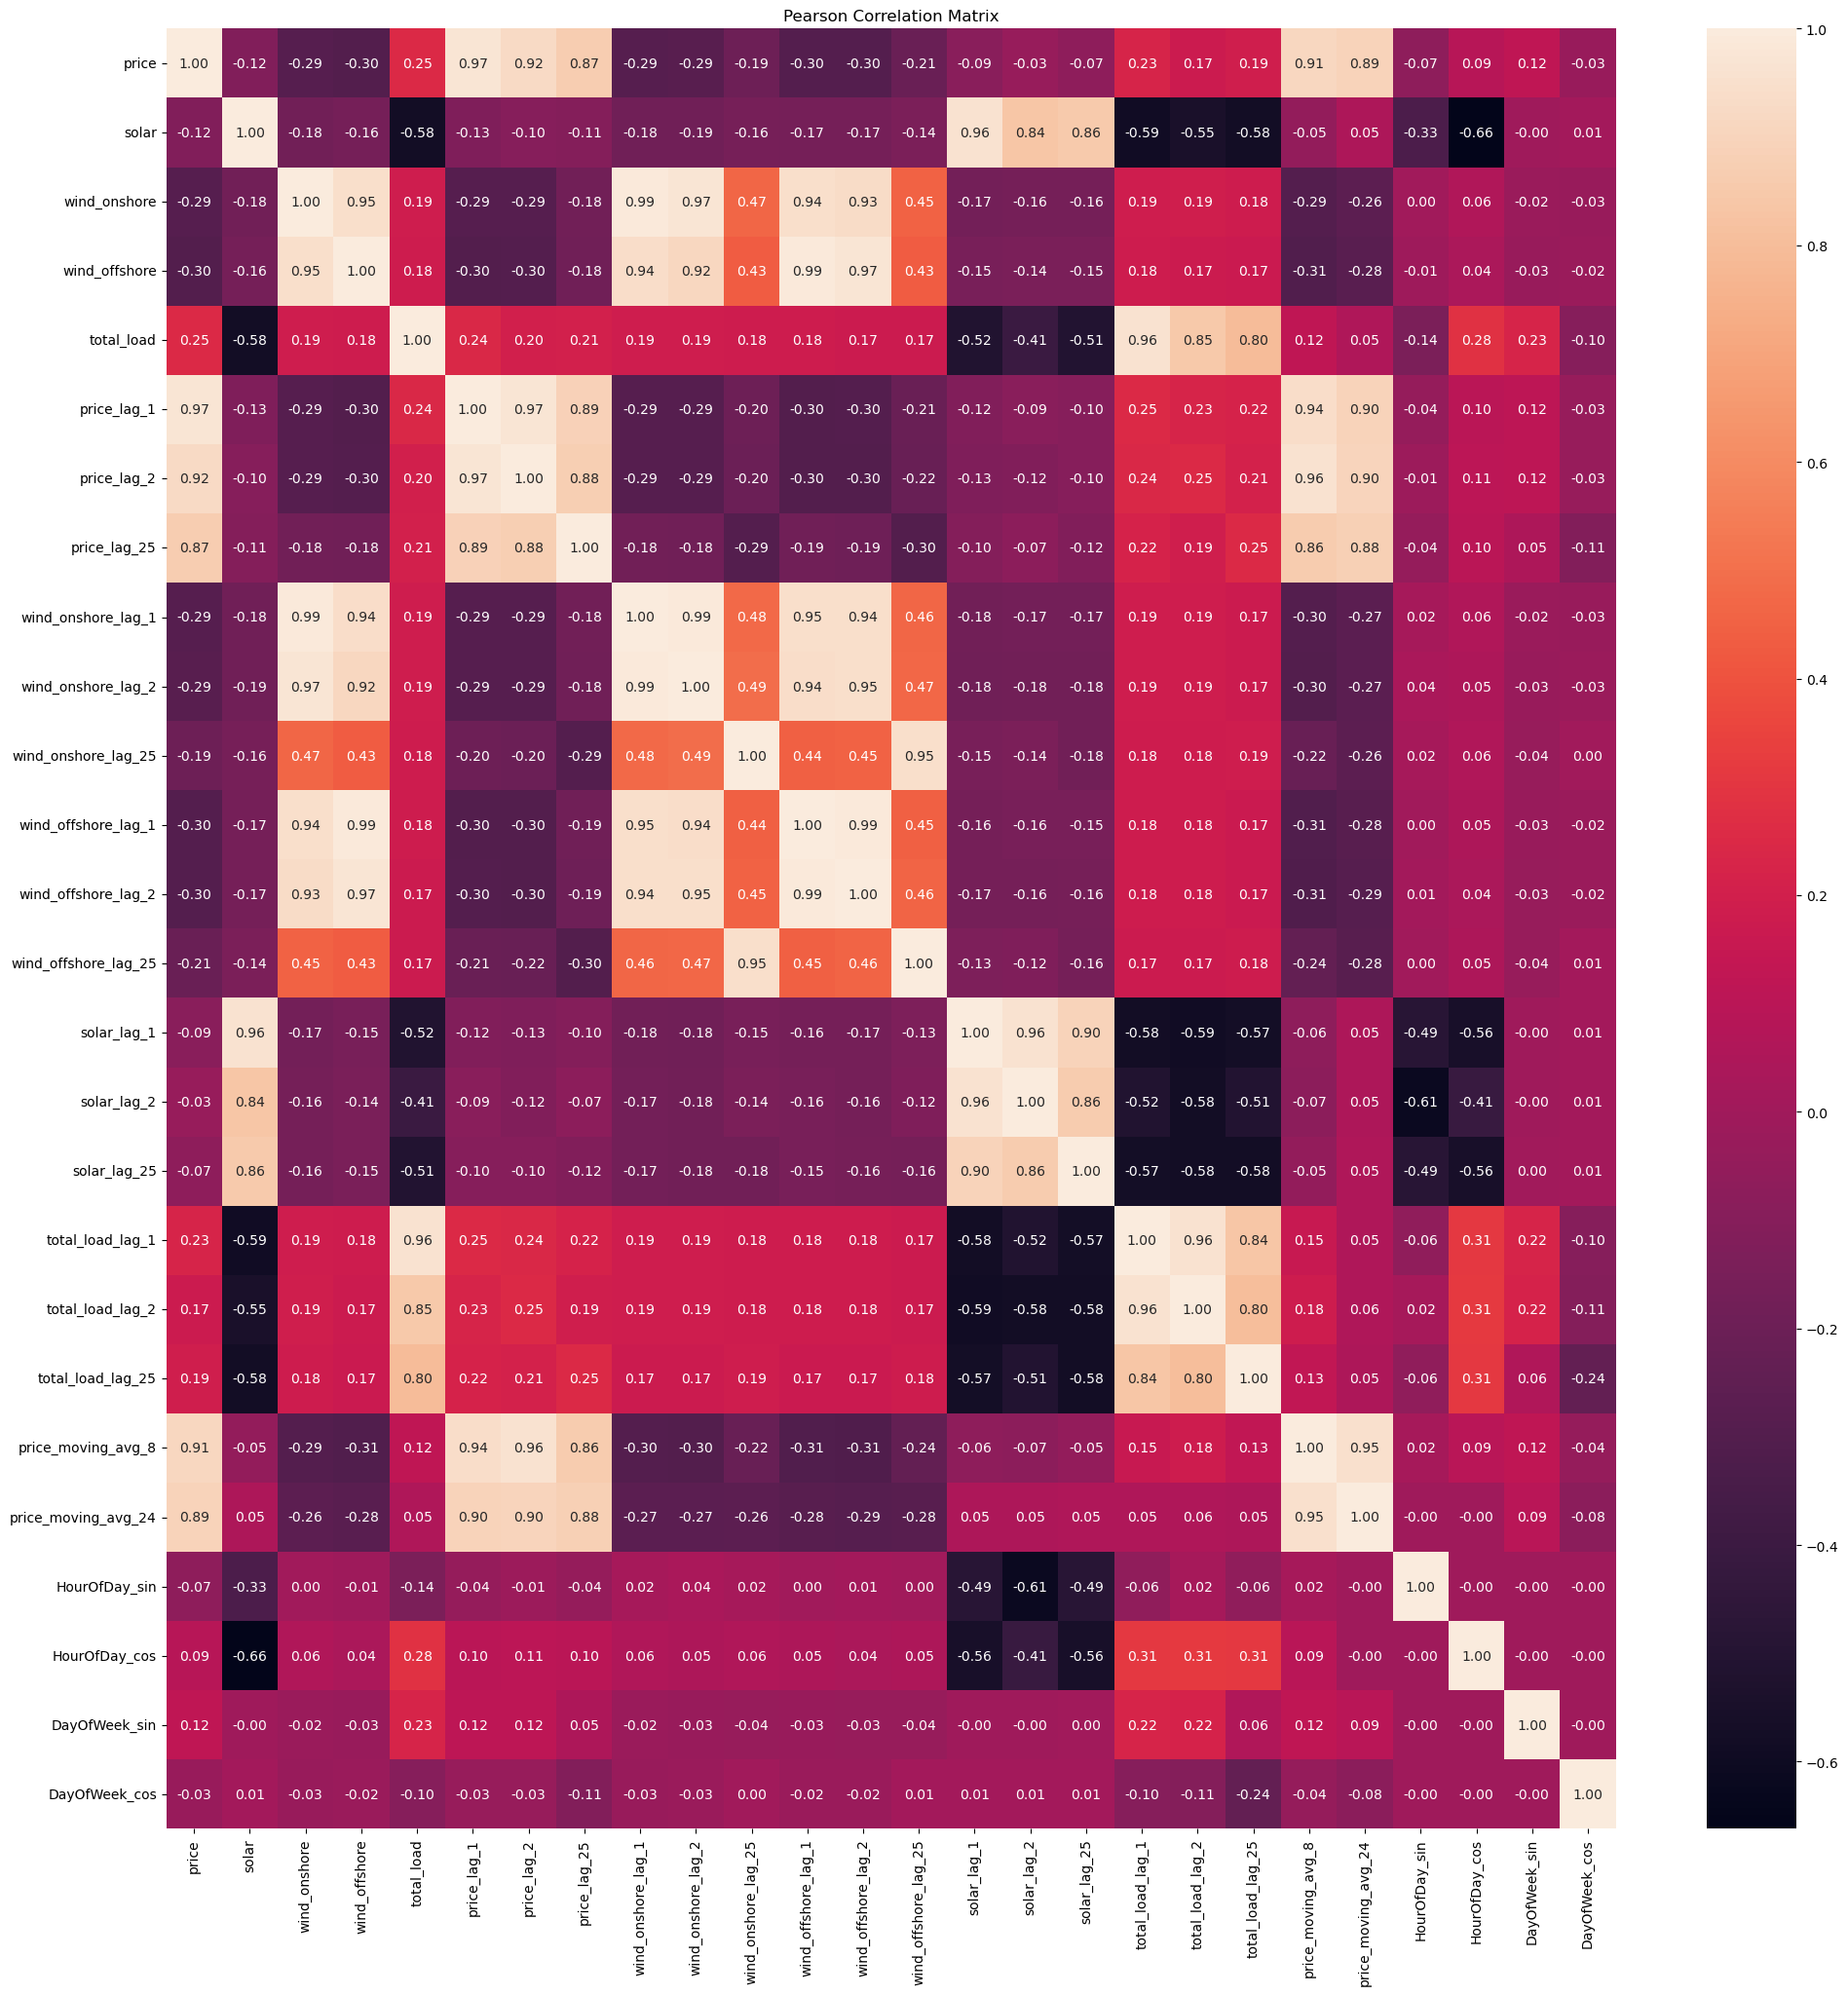

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt 
correlations = df.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [68]:
def eva(y_test, y_pred):
    
    # Inverse scale predictions and actual values
    y_pred_rescaled = scaler.inverse_transform(
        np.concatenate((y_pred, X_test[:, -1, 1:]), axis=1)
    )[:, 0]
    y_test_rescaled = scaler.inverse_transform(
        np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1)
    )[:, 0]
    
    # Calculate MAE
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
                   
    def smape(y_true, y_pred):
        return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    
    
    smape_value = smape(y_test_rescaled, y_pred_rescaled)
    print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape_value:.2f}")
    return y_test_rescaled, y_pred_rescaled

## LSTM

In [69]:
# df = df.loc[:, ['price', '','']]

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24841 entries, 2022-01-01 00:00:00 to 2024-11-01 00:00:00
Freq: h
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 24841 non-null  float64
 1   solar                 24841 non-null  int64  
 2   wind_onshore          24841 non-null  int64  
 3   wind_offshore         24841 non-null  int64  
 4   total_load            24841 non-null  int64  
 5   price_lag_1           24840 non-null  float64
 6   price_lag_2           24839 non-null  float64
 7   price_lag_25          24816 non-null  float64
 8   wind_onshore_lag_1    24840 non-null  float64
 9   wind_onshore_lag_2    24839 non-null  float64
 10  wind_onshore_lag_25   24816 non-null  float64
 11  wind_offshore_lag_1   24840 non-null  float64
 12  wind_offshore_lag_2   24839 non-null  float64
 13  wind_offshore_lag_25  24816 non-null  float64
 14  solar_lag_1           24840

In [71]:
df = df.loc[:,['price','price_lag_1', 'price_lag_2','price_lag_25']]

In [72]:
df = df.dropna()
features = df.columns.tolist()
df = df[features]

In [73]:
train_df = df['2022': '2023']
test_df = df['2024': '2024']

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24816 entries, 2022-01-02 01:00:00 to 2024-11-01 00:00:00
Freq: h
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         24816 non-null  float64
 1   price_lag_1   24816 non-null  float64
 2   price_lag_2   24816 non-null  float64
 3   price_lag_25  24816 non-null  float64
dtypes: float64(4)
memory usage: 1.5 MB


In [75]:
# 32.19
# 28.14
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

# Step 3: Create Sequences Function
def create_sequences_2(data, seq_length=24, target_column='price'):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # Include all features in X
        y.append(data[target_column].iloc[i+seq_length])  # Target is still the original 'price'
    return np.array(X), np.array(y)

# Convert scaled data to DataFrame for consistency in `create_sequences` function
train_scaled_df = pd.DataFrame(train_scaled, columns=features)
test_scaled_df = pd.DataFrame(test_scaled, columns=features)

# Generate sequences for LSTM model
X_train, y_train = create_sequences_2(train_scaled_df)
X_test, y_test = create_sequences_2(test_scaled_df)

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
# model.add(LSTM(50, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(1))  # Output layer for regression


# multivariate_lstm = tf.keras.models.Sequential([
#     LSTM(100, input_shape=input_shape, 
#          return_sequences=True),
#     Flatten(),
#     Dense(200, activation='relu'),
#     Dropout(0.1),
#     Dense(1)
# ])


model.compile(optimizer='adam', loss='mean_squared_error')
# loss =tf. keras.losses.MeanSquaredError()
# metric = [tf.keras.metrics.RootMeanSquaredError()]
# optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)
# multivariate_lstm.compile(loss=loss,
#                           optimizer=optimizer,
#                           metrics=metric)

# Early stopping can be omitted if not needed; here, it’s kept with training loss monitoring.
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Fit the model without validation data
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 6: Evaluate the Model on the Test Set
# Calculate the test loss
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

y_pred = model.predict(X_test)

eva(y_test, y_pred)

"""
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 24816 non-null  float64
 1   solar                 24816 non-null  int64  
 2   wind_onshore          24816 non-null  int64  
 3   wind_offshore         24816 non-null  int64  
 4   total_load            24816 non-null  int64  
 5   price_lag_1           24816 non-null  float64
 6   price_lag_2           24816 non-null  float64
 7   price_lag_25          24816 non-null  float64
 8   wind_onshore_lag_1    24816 non-null  float64
 9   wind_onshore_lag_2    24816 non-null  float64
 10  wind_onshore_lag_25   24816 non-null  float64
 11  wind_offshore_lag_1   24816 non-null  float64
 12  wind_offshore_lag_2   24816 non-null  float64
 13  wind_offshore_lag_25  24816 non-null  float64
 14  solar_lag_1           24816 non-null  float64
 15  solar_lag_2           24816 non-null  float64
 16  solar_lag_25          24816 non-null  float64
 17  total_load_lag_1      24816 non-null  float64
 18  total_load_lag_2      24816 non-null  float64
 19  total_load_lag_25     24816 non-null  float64
 20  price_moving_avg_8    24816 non-null  float64
 21  price_moving_avg_24   24816 non-null  float64
 """

Epoch 1/20


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0064
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0012
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0011
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 8.6156e-04
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 7.7937e-04
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 6.5153e-04
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 6.0617e-04
Epoch 8/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 5.5000e-04
Epoch 9/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 4.8938e-04
Epoch 10/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 4.8396e-04
Epoch 11/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 4.5955e-04
Epoch 12/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 4.4566e-04
Epoch 13/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 4.2871e-04
Epoch 14/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 4.1590e-04
Epoch 15/2

'\n #   Column                Non-Null Count  Dtype  \n---  ------                --------------  -----  \n 0   price                 24816 non-null  float64\n 1   solar                 24816 non-null  int64  \n 2   wind_onshore          24816 non-null  int64  \n 3   wind_offshore         24816 non-null  int64  \n 4   total_load            24816 non-null  int64  \n 5   price_lag_1           24816 non-null  float64\n 6   price_lag_2           24816 non-null  float64\n 7   price_lag_25          24816 non-null  float64\n 8   wind_onshore_lag_1    24816 non-null  float64\n 9   wind_onshore_lag_2    24816 non-null  float64\n 10  wind_onshore_lag_25   24816 non-null  float64\n 11  wind_offshore_lag_1   24816 non-null  float64\n 12  wind_offshore_lag_2   24816 non-null  float64\n 13  wind_offshore_lag_25  24816 non-null  float64\n 14  solar_lag_1           24816 non-null  float64\n 15  solar_lag_2           24816 non-null  float64\n 16  solar_lag_25          24816 non-null  float64\n 17  tota

In [48]:
eva(y_test, y_pred)

Mean Absolute Error (MAE): 9.63
Root Mean Squared Error (RMSE): 14.29
Symmetric Mean Absolute Percentage Error (sMAPE): 27.24


(array([ 35.55,  29.39,  19.6 , ..., 107.  , 107.4 , 101.72]),
 array([ 40.53203878,  27.89431417,  24.16205028, ...,  93.79037607,
         95.58919284, 100.61558333]))

In [322]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Baseline performance
baseline_preds = model.predict(X_test)
baseline_mse = mean_squared_error(y_test, baseline_preds)

# Test the importance of a specific feature
def permute_feature(X, feature_idx):
    X_permuted = X.copy()
    np.random.shuffle(X_permuted[:, :, feature_idx])  # Shuffle along the specific feature axis
    return X_permuted

score = []
for i in range(22):
    # Permute the feature and get the new MSE
    feature_idx = i  # Change to the index of the feature you want to test
    X_test_permuted = permute_feature(X_test, feature_idx)
    permuted_preds = model.predict(X_test_permuted)
    
    permuted_preds_rescaled = scaler.inverse_transform(
        np.concatenate((permuted_preds, X_test[:, -1, 1:]), axis=1)
    )[:, 0]
    y_test_rescaled = scaler.inverse_transform(
        np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1)
    )[:, 0]
    
    permuted_mse = mean_squared_error(y_test, permuted_preds)
    
    # Calculate importance as the difference in MSE
    importance = permuted_preds_rescaled - y_test_rescaled
    # print(f"Importance of feature {feature_idx}: {importance}")
    score.append(permuted_mse)
print(score)

229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[0.0010271038358444476, 0.0004552153954054397, 0.00024621

In [49]:
cols = df.columns.tolist()

In [50]:
# Step 1: Combine the lists into a dictionary
data_dict = dict(zip(cols, score))

# Step 2: Sort the dictionary by values in ascending order
sorted_dict = dict(sorted(data_dict.items(), key=lambda item: item[1]))

print("Sorted dictionary:", sorted_dict)

NameError: name 'score' is not defined

In [51]:
# Separate the keys and values for plotting
keys = list(sorted_dict.keys())
values = list(sorted_dict.values())

# Plot as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()

NameError: name 'sorted_dict' is not defined

## Without generation

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24816 entries, 2022-01-02 01:00:00 to 2024-11-01 00:00:00
Freq: h
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 24816 non-null  float64
 1   solar                 24816 non-null  int64  
 2   wind_onshore          24816 non-null  int64  
 3   wind_offshore         24816 non-null  int64  
 4   total_load            24816 non-null  int64  
 5   price_lag_1           24816 non-null  float64
 6   price_lag_2           24816 non-null  float64
 7   price_lag_25          24816 non-null  float64
 8   wind_onshore_lag_1    24816 non-null  float64
 9   wind_onshore_lag_2    24816 non-null  float64
 10  wind_onshore_lag_25   24816 non-null  float64
 11  wind_offshore_lag_1   24816 non-null  float64
 12  wind_offshore_lag_2   24816 non-null  float64
 13  wind_offshore_lag_25  24816 non-null  float64
 14  solar_lag_1           24816

In [41]:
features = ['price', 'price_lag_1', 'price_lag_2','price_lag_25', 'price_moving_avg_8','price_moving_avg_24']
df = df[features]

In [42]:
df = df.dropna()
features = df.columns.tolist()
df = df[features]

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24816 entries, 2022-01-02 01:00:00 to 2024-11-01 00:00:00
Freq: h
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                24816 non-null  float64
 1   price_lag_1          24816 non-null  float64
 2   price_lag_2          24816 non-null  float64
 3   price_lag_25         24816 non-null  float64
 4   price_moving_avg_8   24816 non-null  float64
 5   price_moving_avg_24  24816 non-null  float64
dtypes: float64(6)
memory usage: 1.8 MB


In [44]:
# without generation
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

# Step 3: Create Sequences Function
def create_sequences_2(data, seq_length=24, target_column='price'):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # Include all features in X
        y.append(data[target_column].iloc[i+seq_length])  # Target is still the original 'price'
    return np.array(X), np.array(y)

# Convert scaled data to DataFrame for consistency in `create_sequences` function
train_scaled_df = pd.DataFrame(train_scaled, columns=features)
test_scaled_df = pd.DataFrame(test_scaled, columns=features)

# Generate sequences for LSTM model
X_train, y_train = create_sequences_2(train_scaled_df)
X_test, y_test = create_sequences_2(test_scaled_df)

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
# model.add(LSTM(50, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(1))  # Output layer for regression


# multivariate_lstm = tf.keras.models.Sequential([
#     LSTM(100, input_shape=input_shape, 
#          return_sequences=True),
#     Flatten(),
#     Dense(200, activation='relu'),
#     Dropout(0.1),
#     Dense(1)
# ])


model.compile(optimizer='adam', loss='mean_squared_error')
# loss =tf. keras.losses.MeanSquaredError()
# metric = [tf.keras.metrics.RootMeanSquaredError()]
# optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)
# multivariate_lstm.compile(loss=loss,
#                           optimizer=optimizer,
#                           metrics=metric)

# Early stopping can be omitted if not needed; here, it’s kept with training loss monitoring.
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Fit the model without validation data
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 6: Evaluate the Model on the Test Set
# Calculate the test loss
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

y_pred = model.predict(X_test)

eva(y_test, y_pred)

Epoch 1/50


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0090
Epoch 2/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0013
Epoch 3/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0010
Epoch 4/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 9.0701e-04
Epoch 5/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 8.0277e-04
Epoch 6/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 6.7860e-04
Epoch 7/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 6.0521e-04
Epoch 8/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 5.8605e-04
Epoch 9/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 5.2712e-04
Epoch 10/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 4.9482e-04
Epoch 11/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 4.7888e-04
Epoch 12/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 4.2483e-04
Epoch 13/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 4.1723e-04
Epoch 14/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 4.0629e-04
Epoch 1

In [ ]:
# Mean Absolute Error (MAE): 9.77
# Root Mean Squared Error (RMSE): 13.70
# Symmetric Mean Absolute Percentage Error (sMAPE): 26.46

In [198]:
t[:24]

array([ 29.39,  19.6 ,  27.33,  16.2 ,   9.5 ,  11.2 ,  44.43,  56.56,
        64.28,  66.12,  70.6 ,  78.8 ,  99.9 , 102.5 , 110.6 , 105.7 ,
       100.7 , 118.93,  81.3 ,  70.1 ,  66.7 ,  54.9 ,  53.18,  54.9 ])

In [199]:
p = y_pred_rescaled[1:]
t = y_test_rescaled[1:]

res_day = []
for i in range(0,304):
    pred = p[i * 24: 24 * (i+1)]
    test = t[i * 24: 24 * (i+1)]
    res = abs(pred - test) / (abs(pred) + abs(test))
    res_day.append(2 * res.sum())
res_day_sum = np.array(res_day).sum()
res_day_sum / (24 * 304)


In [ ]:
0, 24
24, 48

In [98]:
7296 /24

304.0

## Improvement

In [208]:
import pywt

# Define the features to decompose
features_to_decompose = df.columns.tolist()

# Function to apply wavelet decomposition to each feature
def wavelet_decompose(series, wavelet='db1', level=3):
    coeffs = pywt.wavedec(series, wavelet, level=level)  # Decompose signal into frequency components
    decomposed_data = pd.DataFrame(coeffs).T  # Convert to DataFrame
    decomposed_data.columns = [f'{series.name}_wavelet_{i}' for i in range(len(coeffs))]
    return decomposed_data

# Apply wavelet decomposition to each feature and store the decomposed components
decomposed_features = []
for feature in features_to_decompose:
    print('decompose:', feature)
    decomposed = wavelet_decompose(df[feature], wavelet='db1', level=3)
    decomposed.index = df.index[:len(decomposed)]  # Align indices with the original data
    decomposed_features.append(decomposed)

# Concatenate decomposed features with the original data
decomposed_data = pd.concat(decomposed_features, axis=1)
data_with_wavelets = pd.concat([df, decomposed_data], axis=1).dropna()



decompose: price
decompose: solar
decompose: wind_onshore
decompose: wind_offshore
decompose: total_load


In [209]:
data_with_wavelets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3106 entries, 2022-01-01 00:00:00 to 2022-05-10 09:00:00
Freq: h
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    3106 non-null   float64
 1   solar                    3106 non-null   int64  
 2   wind_onshore             3106 non-null   int64  
 3   wind_offshore            3106 non-null   int64  
 4   total_load               3106 non-null   int64  
 5   price_wavelet_0          3106 non-null   float64
 6   price_wavelet_1          3106 non-null   float64
 7   price_wavelet_2          3106 non-null   float64
 8   price_wavelet_3          3106 non-null   float64
 9   solar_wavelet_0          3106 non-null   float64
 10  solar_wavelet_1          3106 non-null   float64
 11  solar_wavelet_2          3106 non-null   float64
 12  solar_wavelet_3          3106 non-null   float64
 13  wind_onshore_wavelet_0   3106 non-

In [210]:
df = data_with_wavelets.copy()

In [200]:
features = ['price', 'price_wavelet_0','price_wavelet_1','price_wavelet_2','price_wavelet_3']
df = df[features]

In [211]:
train_df = df['2022': '2023']
test_df = df['2024': '2024']

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3106 entries, 2022-01-01 00:00:00 to 2022-05-10 09:00:00
Freq: h
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            3106 non-null   float64
 1   price_wavelet_0  3106 non-null   float64
 2   price_wavelet_1  3106 non-null   float64
 3   price_wavelet_2  3106 non-null   float64
 4   price_wavelet_3  3106 non-null   float64
dtypes: float64(5)
memory usage: 210.1 KB


In [212]:
features = df.columns.tolist()


In [213]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

# Step 3: Create Sequences Function
def create_sequences_2(data, seq_length=24, target_column='price'):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # Include all features in X
        y.append(data[target_column].iloc[i+seq_length])  # Target is still the original 'price'
    return np.array(X), np.array(y)

# Convert scaled data to DataFrame for consistency in `create_sequences` function
train_scaled_df = pd.DataFrame(train_scaled, columns=features)
test_scaled_df = pd.DataFrame(test_scaled, columns=features)

# Generate sequences for LSTM model
X_train, y_train = create_sequences_2(train_scaled_df)
X_test, y_test = create_sequences_2(test_scaled_df)

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
# model.add(LSTM(50, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(1))  # Output layer for regression


# multivariate_lstm = tf.keras.models.Sequential([
#     LSTM(100, input_shape=input_shape, 
#          return_sequences=True),
#     Flatten(),
#     Dense(200, activation='relu'),
#     Dropout(0.1),
#     Dense(1)
# ])


model.compile(optimizer='adam', loss='mean_squared_error')
# loss =tf. keras.losses.MeanSquaredError()
# metric = [tf.keras.metrics.RootMeanSquaredError()]
# optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)
# multivariate_lstm.compile(loss=loss,
#                           optimizer=optimizer,
#                           metrics=metric)

# Early stopping can be omitted if not needed; here, it’s kept with training loss monitoring.
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Fit the model without validation data
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 6: Evaluate the Model on the Test Set
# Calculate the test loss
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

y_pred = model.predict(X_test)

eva(y_test, y_pred)



ValueError: Found array with 0 sample(s) (shape=(0, 25)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
# Mean Absolute Error (MAE): 10.04
# Root Mean Squared Error (RMSE): 14.74
# Symmetric Mean Absolute Percentage Error (sMAPE): 28.03


## new model structure

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GlobalAveragePooling1D

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24839 entries, 2022-01-01 02:00:00 to 2024-11-01 00:00:00
Freq: h
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                24839 non-null  float64
 1   solar                24839 non-null  int64  
 2   wind_onshore         24839 non-null  int64  
 3   wind_offshore        24839 non-null  int64  
 4   total_load           24839 non-null  int64  
 5   wind_onshore_lag_1   24839 non-null  float64
 6   wind_onshore_lag_2   24839 non-null  float64
 7   wind_offshore_lag_1  24839 non-null  float64
 8   wind_offshore_lag_2  24839 non-null  float64
 9   solar_lag_1          24839 non-null  float64
 10  solar_lag_2          24839 non-null  float64
 11  total_load_lag_1     24839 non-null  float64
 12  total_load_lag_2     24839 non-null  float64
dtypes: float64(9), int64(4)
memory usage: 3.2 MB


In [17]:
# 32.19
# 28.14
features = df.columns.tolist()
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

# Step 3: Create Sequences Function
def create_sequences_2(data, seq_length=24, target_column='price'):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # Include all features in X
        y.append(data[target_column].iloc[i+seq_length])  # Target is still the original 'price'
    return np.array(X), np.array(y)

def create_sequences_multi_step(data, seq_length=24, target_length=1, target_column='price'):
    X, y = [], []
    for i in range(len(data) - seq_length - target_length + 1):
        X.append(data.iloc[i:i+seq_length].values)  # Input sequence
        y.append(data[target_column].iloc[i+seq_length:i+seq_length+target_length].values)  # Next 24 hours as target
    return np.array(X), np.array(y)


# Convert scaled data to DataFrame for consistency in `create_sequences` function
train_scaled_df = pd.DataFrame(train_scaled, columns=features)
test_scaled_df = pd.DataFrame(test_scaled, columns=features)

# Generate sequences for LSTM model
X_train, y_train = create_sequences_2(train_scaled_df)
X_test, y_test = create_sequences_2(test_scaled_df)

# Step 4: Build the LSTM Model
# Build the LSTM model
model = Sequential()

# First LSTM layer with return_sequences=True to stack more LSTM layers
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

# GlobalAveragePooling instead of Flatten to keep temporal context
model.add(GlobalAveragePooling1D())

# Dense layer after pooling
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))

# Output layer for regression
model.add(Dense(1))
# model.add(Dense(24))


model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping can be omitted if not needed; here, it’s kept with training loss monitoring.
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Fit the model without validation data
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 6: Evaluate the Model on the Test Set
# Calculate the test loss
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

y_pred = model.predict(X_test)

eva(y_test, y_pred)

"""
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 24816 non-null  float64
 1   solar                 24816 non-null  int64  
 2   wind_onshore          24816 non-null  int64  
 3   wind_offshore         24816 non-null  int64  
 4   total_load            24816 non-null  int64  
 5   price_lag_1           24816 non-null  float64
 6   price_lag_2           24816 non-null  float64
 7   price_lag_25          24816 non-null  float64
 8   wind_onshore_lag_1    24816 non-null  float64
 9   wind_onshore_lag_2    24816 non-null  float64
 10  wind_onshore_lag_25   24816 non-null  float64
 11  wind_offshore_lag_1   24816 non-null  float64
 12  wind_offshore_lag_2   24816 non-null  float64
 13  wind_offshore_lag_25  24816 non-null  float64
 14  solar_lag_1           24816 non-null  float64
 15  solar_lag_2           24816 non-null  float64
 16  solar_lag_25          24816 non-null  float64
 17  total_load_lag_1      24816 non-null  float64
 18  total_load_lag_2      24816 non-null  float64
 19  total_load_lag_25     24816 non-null  float64
 20  price_moving_avg_8    24816 non-null  float64
 21  price_moving_avg_24   24816 non-null  float64
 """


Epoch 1/50


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0211
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0026
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0023
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0019
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0018
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0016
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0015
Epoch 8/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0015
Epoch 9/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0014
Epoch 10/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0014
Epoch 11/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0013
Epoch 12/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0012
Epoch 13/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0012
Epoch 14/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0011
Epoch 15/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/s

'\n #   Column                Non-Null Count  Dtype  \n---  ------                --------------  -----  \n 0   price                 24816 non-null  float64\n 1   solar                 24816 non-null  int64  \n 2   wind_onshore          24816 non-null  int64  \n 3   wind_offshore         24816 non-null  int64  \n 4   total_load            24816 non-null  int64  \n 5   price_lag_1           24816 non-null  float64\n 6   price_lag_2           24816 non-null  float64\n 7   price_lag_25          24816 non-null  float64\n 8   wind_onshore_lag_1    24816 non-null  float64\n 9   wind_onshore_lag_2    24816 non-null  float64\n 10  wind_onshore_lag_25   24816 non-null  float64\n 11  wind_offshore_lag_1   24816 non-null  float64\n 12  wind_offshore_lag_2   24816 non-null  float64\n 13  wind_offshore_lag_25  24816 non-null  float64\n 14  solar_lag_1           24816 non-null  float64\n 15  solar_lag_2           24816 non-null  float64\n 16  solar_lag_25          24816 non-null  float64\n 17  tota

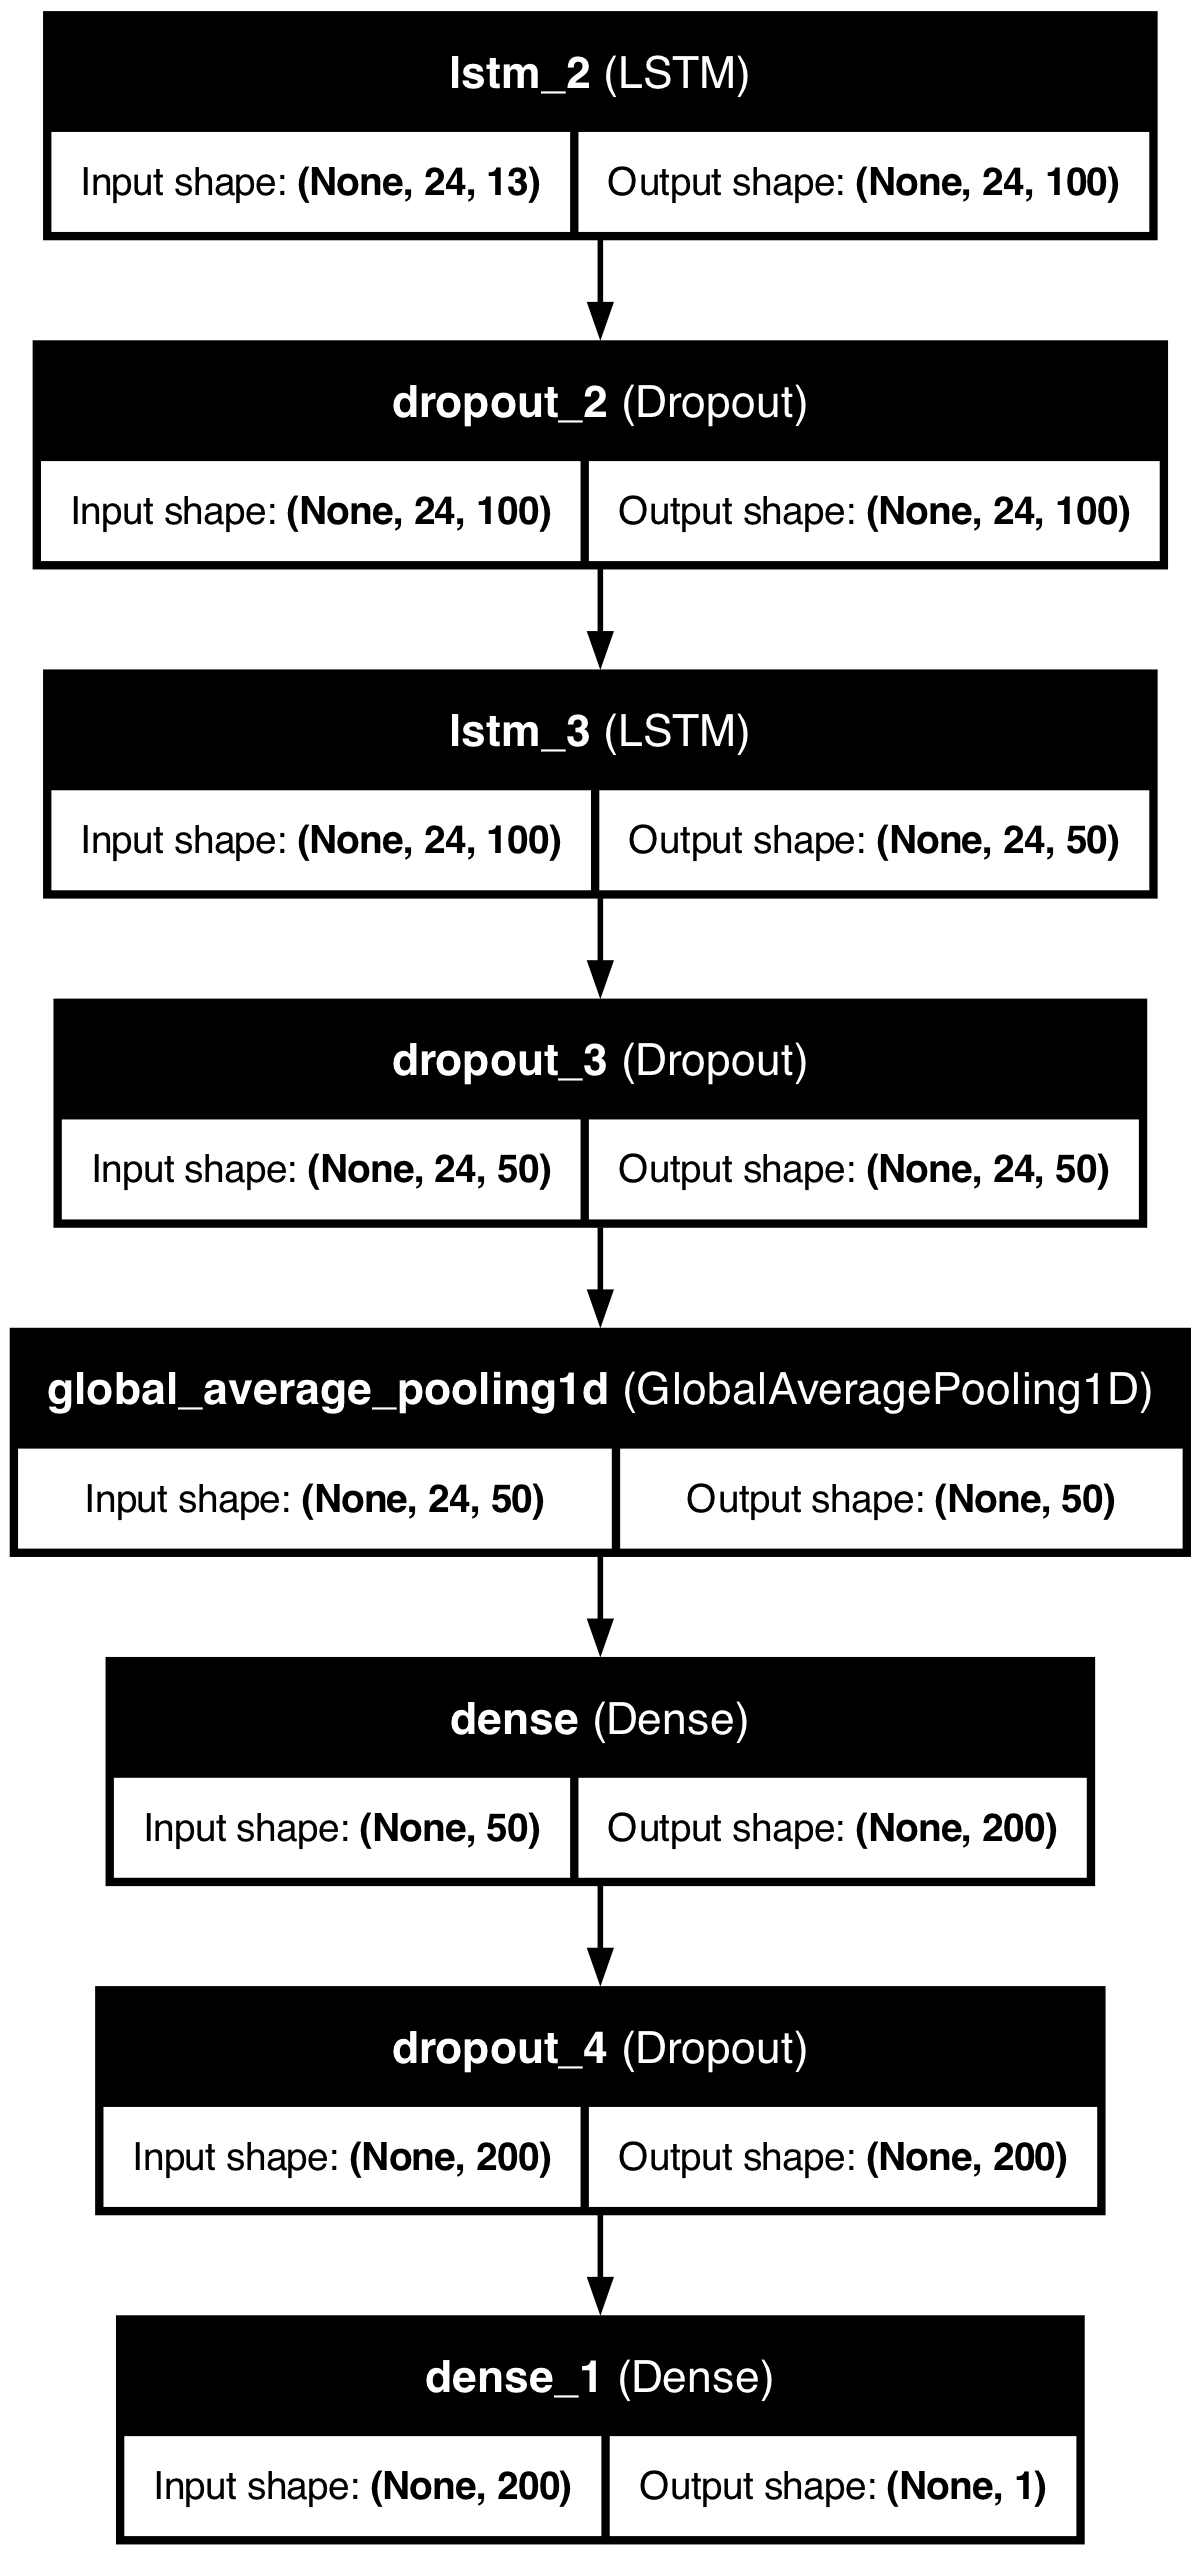

In [19]:
from keras.utils import plot_model

# Visualize the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [251]:
p = y_pred_rescaled[1:]
t = y_test_rescaled[1:]

res_day = []
for i in range(0,304):
    pred = p[i * 24: 24 * (i+1)]
    test = t[i * 24: 24 * (i+1)]
    res = abs(pred - test) / (abs(pred) + abs(test))
    res_day.append(2 * res.sum())
res_day_sum = np.array(res_day).sum()
res_day_sum / (24 * 304)

0.37731672576647396

In [277]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[['price']])
test_scaled = scaler.transform(test_df[['price']])

# Parameters
seq_length = 24  # Number of past time steps to include in each sequence

# Step 1: Create Sequences
def create_sequences(data, seq_length = 24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # Sequence of 'price' values
        y.append(data.iloc[i+seq_length])  # Target value (next 'price' value)
    return np.array(X), np.array(y)

# Convert scaled data to DataFrame for consistency in `create_sequences` function
train_scaled_df = pd.DataFrame(train_scaled, columns=['price'])
test_scaled_df = pd.DataFrame(test_scaled, columns=['price'])

# Generate sequences for LSTM model
X_train, y_train = create_sequences(train_scaled_df)
X_test, y_test = create_sequences(test_scaled_df)

# Step 4: Build the LSTM Model
# Build the LSTM model
model = Sequential()

# First LSTM layer with return_sequences=True to stack more LSTM layers
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

# GlobalAveragePooling instead of Flatten to keep temporal context
model.add(GlobalAveragePooling1D())

# Dense layer after pooling
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))

# Output layer for regression
model.add(Dense(1))
# model.add(Dense(24))


model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping can be omitted if not needed; here, it’s kept with training loss monitoring.
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Fit the model without validation data
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 6: Evaluate the Model on the Test Set
# Calculate the test loss
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

y_pred = model.predict(X_test)

eva(y_test, y_pred)

Epoch 1/50


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0186
Epoch 2/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0026
Epoch 3/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0023
Epoch 4/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0021
Epoch 5/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0021
Epoch 6/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0019
Epoch 7/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0019
Epoch 8/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0018
Epoch 9/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0017
Epoch 10/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0016
Epoch 11/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.0016
Epoch 12/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0015
Epoch 13/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0014
Epoch 14/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0014
Epoch 15/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s

(array([ 35.55,  29.39,  19.6 , ..., 107.  , 107.4 , 101.72]),
 array([ 46.99989337,  34.73839828,  29.62796086, ...,  95.69485417,
         92.74557099, 101.00182331]))